In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
from surprise.model_selection import KFold, train_test_split, cross_validate
from collections import Counter
from surprise import Dataset, KNNWithMeans, Reader, accuracy, NMF, SVD
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from surprise.prediction_algorithms.matrix_factorization import SVD
from sklearn.metrics import mean_squared_error

In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=3366574 sha256=67529fcc93672dc59078b9d145a6112c8ce036294fd85fb18077a109d7b896d6
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [5]:
movies = pd.read_csv("movies.csv")
links = pd.read_csv("links.csv")
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")

### Question 1

#### 1a

In [6]:
new_r = pd.read_csv("ratings.csv", usecols=['userId','movieId','rating','timestamp']) 
user_id = new_r.pop('userId').values
movie_id = new_r.pop('movieId').values

sparsity = len(ratings)/(len(set(user_id))*len(set(movie_id)))
print('Sparsity:'+ str(sparsity))

Sparsity:0.016999683055613623


#### 1b

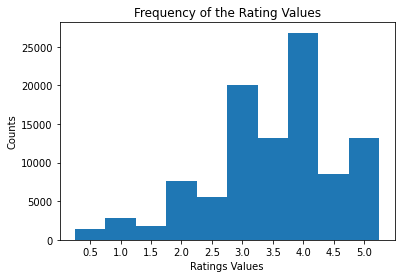

In [7]:
rating_value = ratings["rating"].values
u_ratings, indicies = np.unique(rating_value, return_counts=True)

plt.bar(u_ratings, indicies, width=0.5)
plt.xlabel("Ratings Values")
plt.ylabel("Counts")
plt.xticks(u_ratings)
plt.title("Frequency of the Rating Values")
plt.show()

#### 1c

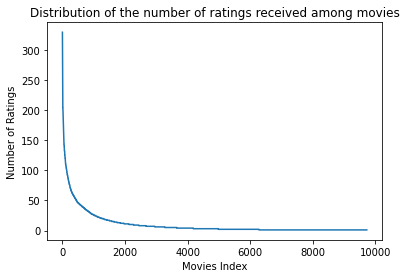

In [8]:
# 1c
unique_movie, ncounts = np.unique(movie_id, return_counts=True)
ncounts = np.sort(ncounts)
plt.plot(ncounts[::-1])
plt.title("Distribution of the number of ratings received among movies")
plt.xlabel("Movies Index")
plt.ylabel("Number of Ratings")
plt.show()

#### 1d

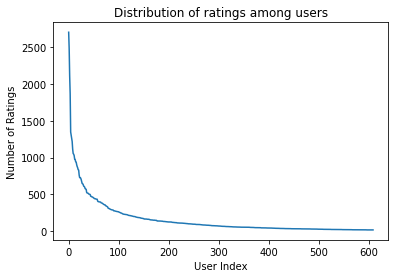

In [9]:
# 1d
unique_movie, ncounts = np.unique(user_id, return_counts=True)
ncounts = np.sort(ncounts)
plt.plot(ncounts[::-1])
plt.title("Distribution of ratings among users")
plt.xlabel("User Index")
plt.ylabel("Number of Ratings")
plt.show()

### 1f

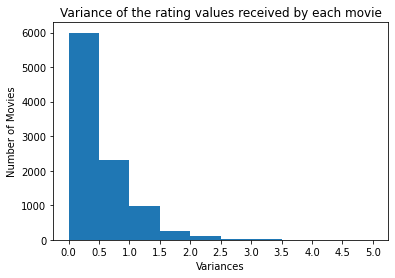

In [10]:
# 1f
bins = np.linspace(0, 5, num=11)
var_lst = np.var(ratings.pivot_table("rating", "userId", "movieId")).values
plt.hist(var_lst, bins=bins)
plt.xticks(bins)
plt.title("Variance of the rating values received by each movie")
plt.xlabel("Variances")
plt.ylabel("Number of Movies")
plt.show()

### Question 4

In [11]:
reader = Reader(rating_scale=(0.5, 5))
data_q4 = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=reader)

rmse_avg = []
mae_avg = []
k_lst = np.arange(2,102,2) 

for k in k_lst:
    knn = KNNWithMeans(k=k,sim_options={'name':'pearson'}, verbose = False)
    cv_knn = cross_validate(knn, data = data_q4, cv=10, verbose = False)
    rmse_avg.append(np.mean(cv_knn['test_rmse']))
    mae_avg.append(np.mean(cv_knn['test_mae']))

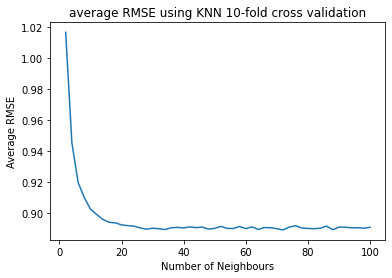

In [12]:
plt.plot(k_lst, rmse_avg)
plt.ylabel('Average RMSE')
plt.xlabel('Number of Neighbours')
plt.title('average RMSE using KNN 10-fold cross validation')
plt.show()
# min_rmse = min(rmse_avg)
# min_k = [k[i] for i in range(len(k)) if rmse_avg[i] == min_rmse][0]
# print("Optimized RMSE on popular trimming movies:", min_rmse)
# print("Optimized corresponding k:", min_k)

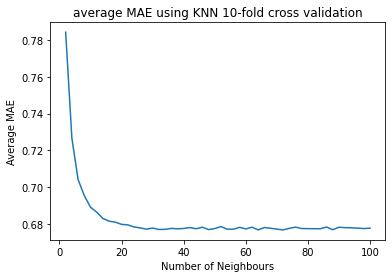

In [13]:
plt.plot(k_lst,mae_avg)
plt.ylabel('Average MAE')
plt.xlabel('Number of Neighbours')
plt.title('average MAE using KNN 10-fold cross validation')
plt.show()

### Question 5

In [14]:
print('k, rmse, mae')
for i in range(len(k_lst)-30):
    print(k_lst[i], rmse_avg[i], mae_avg[i])

k, rmse, mae
2 1.0169148999837574 0.784147223124648
4 0.9453099293604559 0.7266489917858265
6 0.9196213747503773 0.7042318440144723
8 0.9097612724493164 0.695481316995065
10 0.9022872994632107 0.6892161980044645
12 0.898844813736068 0.686526161917284
14 0.8956243945226767 0.6831095819510452
16 0.8937804880852708 0.6816289945204334
18 0.8934213558216644 0.6811087424222961
20 0.8921032597018836 0.6799058981658086
22 0.8916133276796394 0.6796238928126492
24 0.8912940708736826 0.678505126850989
26 0.8901473046865 0.6779751721611038
28 0.88930851001424 0.677291507872129
30 0.8899558931717289 0.6779020617106969
32 0.8896158803259322 0.6771350578405517
34 0.8891135495881851 0.6772018325536702
36 0.8902385572144931 0.6776991224545368
38 0.8904831508173041 0.6774992081551354
40 0.890134200617809 0.6776609592475685


### Question 6

In [15]:
new_ratings = ratings
new_ratings["count"] = ratings.groupby("movieId")["rating"].transform('count')
new_ratings["ratingVar"] = ratings.groupby("movieId")["rating"].transform(lambda x: np.var(x))

#popular movie
popular_movies = np.unique(new_ratings[new_ratings["count"] > 2].movieId)
#unpopular movie
unpopular_movies = np.unique(new_ratings[new_ratings["count"] <= 2].movieId)
#high variance movie trimming
high_varianc_movie = np.unique(new_ratings[(new_ratings["count"] >= 5) & (new_ratings["ratingVar"] >= 2)].movieId)

def trimming(test, method):
    if method == "popular":
        data = popular_movies
    elif method == "unpopular":
        data = unpopular_movies
    else:
        data = high_varianc_movie
    temp = []
    for i in range(len(test)):
        if test[i][1] in data:
          temp.append(test[i])
    return temp
new_ratings = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=Reader(rating_scale=(0, 5)))


In [16]:
new_ratings = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=Reader(rating_scale=(0, 5)))
k = range(2,102,2)
rmse_total_popular = []
rmse_total_unpopular = []
rmse_total_variance = []
for i in k:
    rmse_popular = []
    rmse_unpopular = []
    rmse_variance = []
    knn = KNNWithMeans(k=i, sim_options = {'name':'pearson','user_based':True}, verbose = False)
    for train, test in KFold(n_splits=10).split(new_ratings):
        knn.fit(train)
        popular_trimming_test = trimming(test, method = "popular")
        unpopular_trimming_test = trimming(test, method = "unpopular")
        variance_trimming_test = trimming(test, method = "variance")

        popular_test_pred = knn.test(popular_trimming_test)
        unpopular_test_pred = knn.test(unpopular_trimming_test)
        variance_test_pred = knn.test(variance_trimming_test)

        rmse_popular.append(accuracy.rmse(popular_test_pred, verbose=False))
        rmse_unpopular.append(accuracy.rmse(unpopular_test_pred, verbose=False))
        rmse_variance.append(accuracy.rmse(variance_test_pred, verbose=False))
    rmse_total_popular.append(np.mean(rmse_popular))
    rmse_total_unpopular.append(np.mean(rmse_unpopular))
    rmse_total_variance.append(np.mean(rmse_variance))

In [17]:
def plot_roc(test, pred, title):
    thresholds = [2.5, 3, 3.5, 4]
    fig, axs = plt.subplots(figsize=(10, 10))
    n = 0
    for threshold in thresholds:
        y_true = []
        y_pred = []
        for i in range(len(test)):
            y_pred.append(pred[i].est)
            if test[i][2] >= threshold:
                y_true.append(1)
            else:
                y_true.append(0)
        auc = roc_auc_score(y_true, y_pred)
        fpr, tpr, t = roc_curve(y_true, y_pred)

        axs.plot(fpr, tpr, label = 'Threshold: ' + str(threshold) + " AUC: " + str(auc))
        axs.set_title("ROC curve for " + title)
        axs.set_xlabel("False Positive Rate")
        axs.set_ylabel("True Positive Rate")
        axs.legend()
        axs.plot([0, 1], [0, 1], '--')


Text(0.5, 1.0, 'rmse vs k for popular trimming movies')

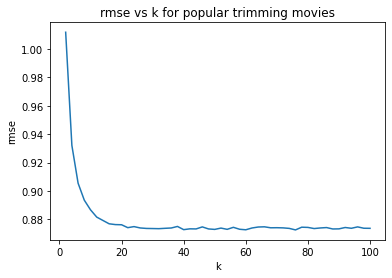

In [18]:
plt.plot(k, rmse_total_popular)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for popular trimming movies")

In [19]:
min_rmse = min(rmse_total_popular)
min_k = [k[i] for i in range(len(k)) if rmse_total_popular[i] == min_rmse][0]
print("Optimized RMSE on popular trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE on popular trimming movies: 0.8726655252345317
Optimized corresponding k: 76


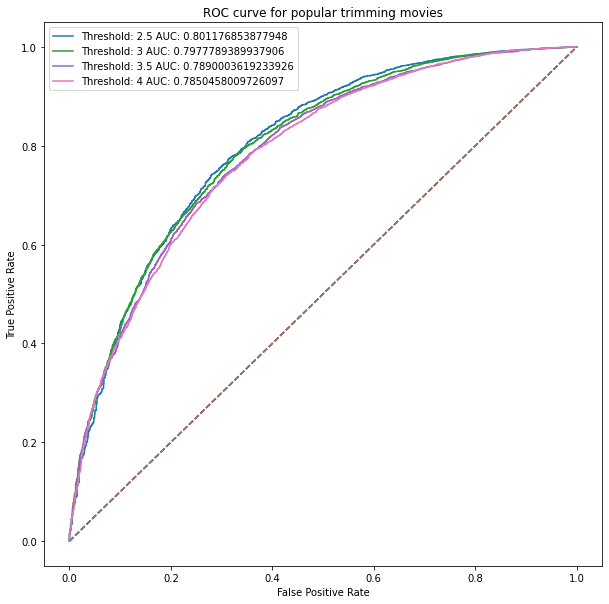

In [20]:
knn = KNNWithMeans(k=min_k, sim_options = {'name':'pearson','user_based':True}, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
popular_trimming_test = trimming(test, method = "popular")
knn.fit(train)
popular_test_pred = knn.test(popular_trimming_test)
plot_roc(popular_trimming_test, popular_test_pred, "popular trimming movies")

Text(0.5, 1.0, 'rmse vs k for unpopular trimming movies')

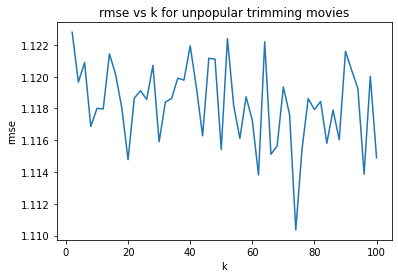

In [21]:
plt.plot(k, rmse_total_unpopular)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for unpopular trimming movies")

In [22]:
min_rmse = min(rmse_total_unpopular)
min_k = [k[i] for i in range(len(k)) if rmse_total_unpopular[i] == min_rmse][0]
print("Optimized RMSE on unpopular trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)


Optimized RMSE on unpopular trimming movies: 1.1103599002992839
Optimized corresponding k: 74


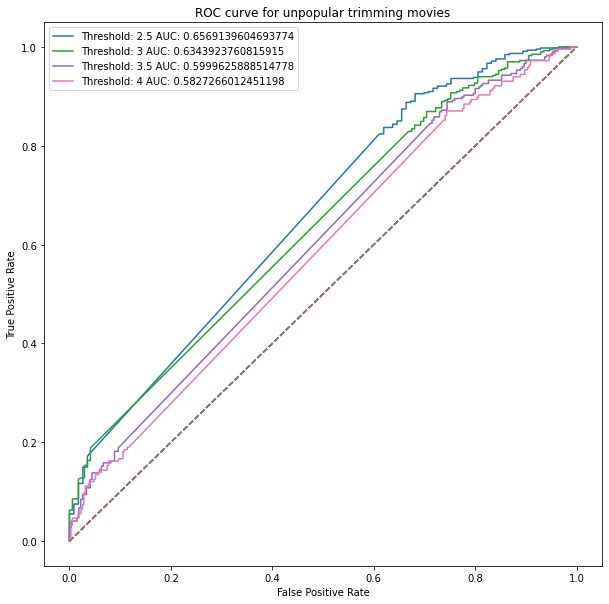

In [23]:
knn = KNNWithMeans(k=min_k, sim_options = {'name':'pearson','user_based':True}, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
popular_trimming_test = trimming(test, method = "unpopular")
knn.fit(train)
popular_test_pred = knn.test(popular_trimming_test)
plot_roc(popular_trimming_test, popular_test_pred, "unpopular trimming movies")

Text(0.5, 1.0, 'rmse vs k for high variance trimming movies')

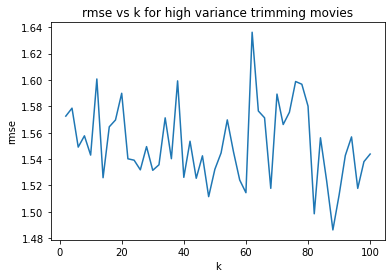

In [24]:
plt.plot(k, rmse_total_variance)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for high variance trimming movies")

In [25]:
min_rmse = min(rmse_total_variance)
min_k = [k[i] for i in range(len(k)) if rmse_total_variance[i] == min_rmse][0]
print("Optimized RMSE on high variance trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)


Optimized RMSE on high variance trimming movies: 1.486316041465336
Optimized corresponding k: 88


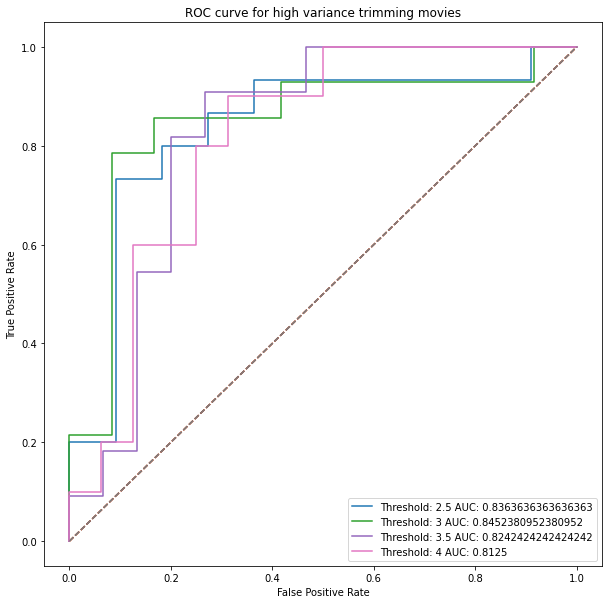

In [26]:
knn = KNNWithMeans(k=min_k, sim_options = {'name':'pearson','user_based':True}, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
popular_trimming_test = trimming(test, method = "variance")
knn.fit(train)
popular_test_pred = knn.test(popular_trimming_test)
plot_roc(popular_trimming_test, popular_test_pred, "high variance trimming movies")

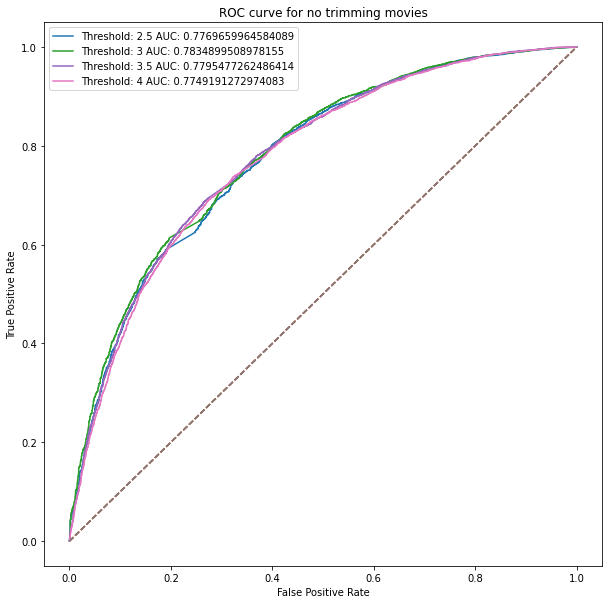

In [27]:
knn = KNNWithMeans(k=min_k, sim_options = {'name':'pearson','user_based':True}, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
knn.fit(train)
test_pred = knn.test(test)
plot_roc(test, test_pred, "no trimming movies")

### Question 7 (based on q5)

### Question 8

#### 8A

In [28]:
k = range(2,52,2)
rmse_total = []
mae_total = []
for i in k:
    rmse = []
    mae = []
    nmf = NMF(n_factors=i, verbose = False)
    cv = cross_validate(nmf, new_ratings, measures=['rmse', 'mae'], cv=10, verbose=False)
    rmse_total.append(np.mean(cv['test_rmse']))
    mae_total.append(np.mean(cv['test_mae']))

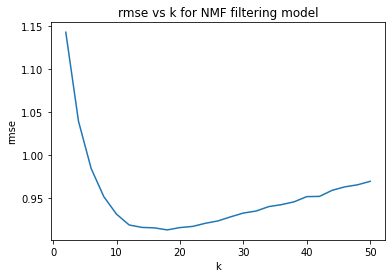

In [29]:
plt.plot(k, rmse_total)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for NMF filtering model")
min_rmse = min(rmse_total)
min_k = [k[i] for i in range(len(k)) if rmse_total[i] == min_rmse][0]

Text(0.5, 1.0, 'mae vs k for NMF filtering model')

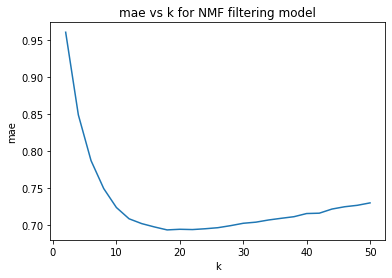

In [30]:
plt.plot(k, mae_total)
plt.xlabel("k")
plt.ylabel("mae")
plt.title("mae vs k for NMF filtering model")


#### 8B

In [31]:
min_rmse = min(rmse_total)
min_k = [k[i] for i in range(len(k)) if rmse_total[i] == min_rmse][0]
print("Optimized RMSE:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE: 0.9124026126204823
Optimized corresponding k: 18


In [32]:
min_mae = min(mae_total)
min_k = [k[i] for i in range(len(k)) if mae_total[i] == min_mae][0]
print("Optimized MAE:", min_mae)
print("Optimized corresponding k:", min_k)

Optimized MAE: 0.6938620544942815
Optimized corresponding k: 18


#### 8C

In [33]:
k = range(2,52,2)
rmse_total_popular = []
rmse_total_unpopular = []
rmse_total_variance = []
for i in k:
    rmse_popular = []
    rmse_unpopular = []
    rmse_variance = []

    rmse_total.append(np.mean(cv['test_rmse']))
    mae_total.append(np.mean(cv['test_mae']))

    nmf = NMF(n_factors=i, verbose = False)
    for train, test in KFold(n_splits=10).split(new_ratings):
        nmf.fit(train)
        popular_trimming_test = trimming(test, method = "popular")
        unpopular_trimming_test = trimming(test, method = "unpopular")
        variance_trimming_test = trimming(test, method = "variance")

        popular_test_pred = nmf.test(popular_trimming_test)
        unpopular_test_pred = nmf.test(unpopular_trimming_test)
        variance_test_pred = nmf.test(variance_trimming_test)

        rmse_popular.append(accuracy.rmse(popular_test_pred, verbose=False))
        rmse_unpopular.append(accuracy.rmse(unpopular_test_pred, verbose=False))
        rmse_variance.append(accuracy.rmse(variance_test_pred, verbose=False))
    rmse_total_popular.append(np.mean(rmse_popular))
    rmse_total_unpopular.append(np.mean(rmse_unpopular))
    rmse_total_variance.append(np.mean(rmse_variance))

Text(0.5, 1.0, 'rmse vs k for popular trimming movies under NMF filtering')

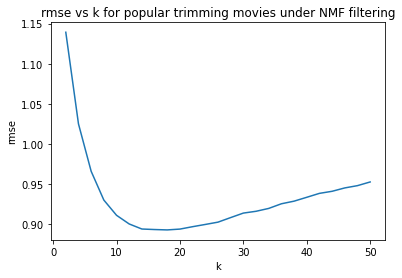

In [34]:
plt.plot(k, rmse_total_popular)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for popular trimming movies under NMF filtering")

In [35]:
min_rmse = min(rmse_total_popular)
min_k = [k[i] for i in range(len(k)) if rmse_total_popular[i] == min_rmse][0]
print("Optimized RMSE on popular trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE on popular trimming movies: 0.8927693844573629
Optimized corresponding k: 18


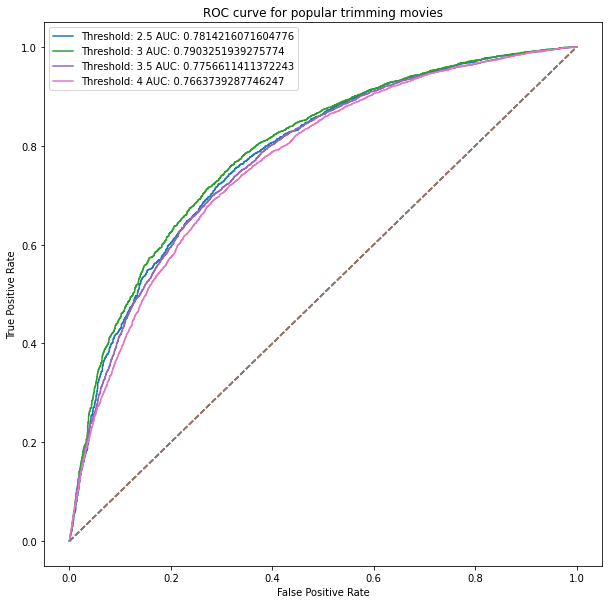

In [36]:
nmf = NMF(n_factors=min_k, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
popular_trimming_test = trimming(test, method = "popular")
nmf.fit(train)
popular_test_pred = nmf.test(popular_trimming_test)
plot_roc(popular_trimming_test, popular_test_pred, "popular trimming movies")

Text(0.5, 1.0, 'rmse vs k for unpopular trimming movies under NMF filtering')

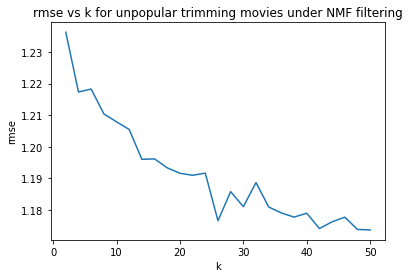

In [37]:
plt.plot(k, rmse_total_unpopular)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for unpopular trimming movies under NMF filtering")

In [38]:
min_rmse = min(rmse_total_unpopular)
min_k = [k[i] for i in range(len(k)) if rmse_total_unpopular[i] == min_rmse][0]
print("Optimized RMSE on unpopular trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE on unpopular trimming movies: 1.17363122866738
Optimized corresponding k: 50


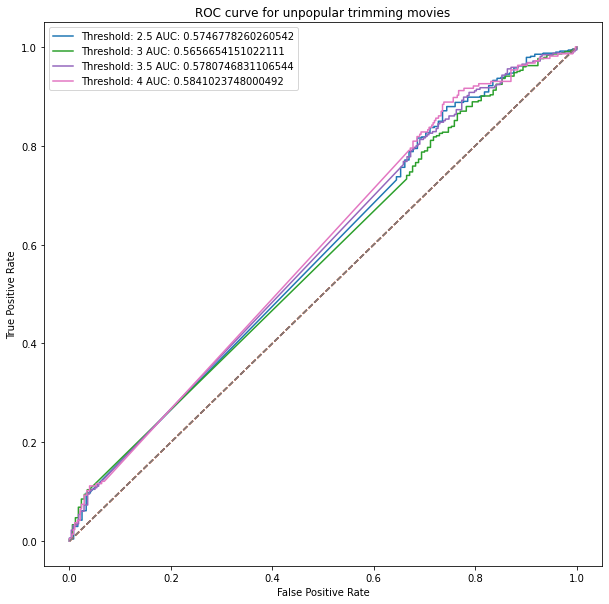

In [39]:
nmf = NMF(n_factors=min_k, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
unpopular_trimming_test = trimming(test, method = "unpopular")
nmf.fit(train)
unpopular_test_pred = nmf.test(unpopular_trimming_test)
plot_roc(unpopular_trimming_test, unpopular_test_pred, "unpopular trimming movies")

Text(0.5, 1.0, 'rmse vs k for high variance trimming movies under NMF filtering')

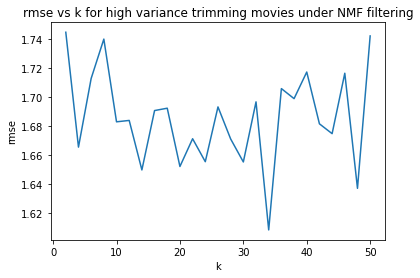

In [40]:
plt.plot(k, rmse_total_variance)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for high variance trimming movies under NMF filtering")

In [41]:
min_rmse = min(rmse_total_variance)
min_k = [k[i] for i in range(len(k)) if rmse_total_variance[i] == min_rmse][0]
print("Optimized RMSE on high variance trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE on high variance trimming movies: 1.6083264743741676
Optimized corresponding k: 34


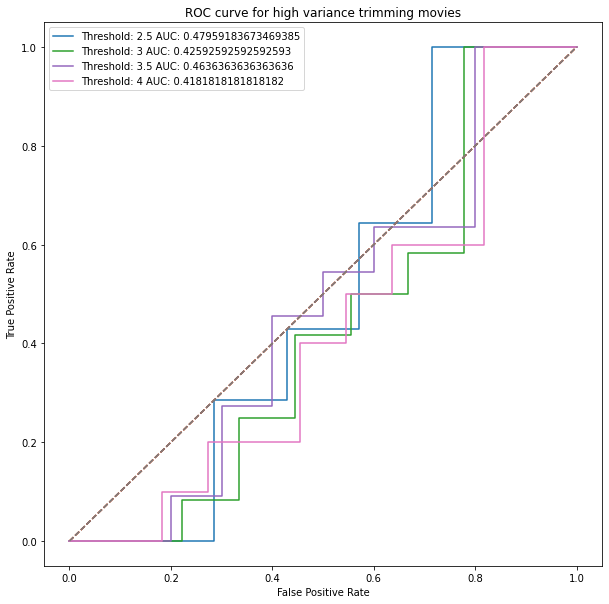

In [42]:
nmf = NMF(n_factors=min_k, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
variance_trimming_test = trimming(test, method = "variance")
nmf.fit(train)
variance_test_pred = nmf.test(variance_trimming_test)
plot_roc(variance_trimming_test, variance_test_pred, "high variance trimming movies")

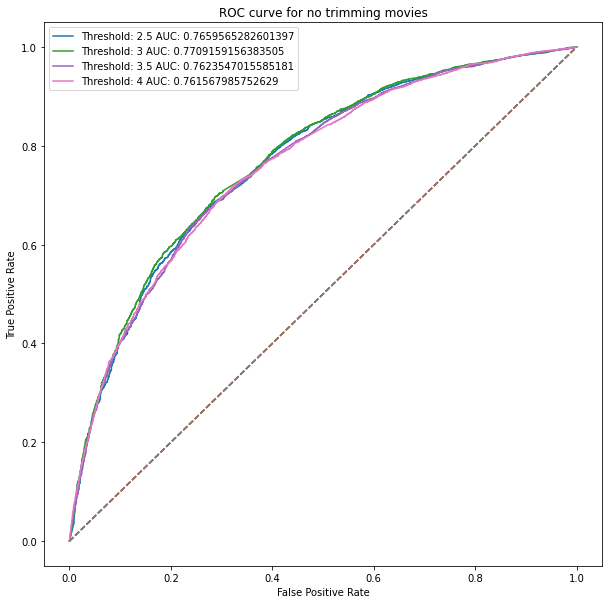

In [43]:
nmf = NMF(n_factors=min_k, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
nmf.fit(train)
test_pred = nmf.test(test)
plot_roc(test, test_pred, "no trimming movies")

### Question 9

In [44]:
from traitlets.traitlets import default
from collections import defaultdict
nmf9 = NMF(n_factors=20, verbose=False)
train, test = train_test_split(new_ratings, test_size=0.1)
nmf9.fit(train)
f = nmf9.qi
for i in [1, 4, 7, 10, 13, 17]:
    print('Factor: ',i)
    top10 = np.argsort(f[:,i])[::-1][:10]
    store = defaultdict(int)
    for i in top10:
        print(movies['genres'][i])
        for i in movies['genres'][i].split('|'):
            store[i] += 1
    print(store)
    print(" ")

Factor:  1
Children|Comedy|Drama
Drama
Comedy
Crime|Film-Noir
Comedy|Drama
Sci-Fi|Thriller
Comedy
Comedy
Action|Animation|Crime
Drama
defaultdict(<class 'int'>, {'Children': 1, 'Comedy': 5, 'Drama': 4, 'Crime': 2, 'Film-Noir': 1, 'Sci-Fi': 1, 'Thriller': 1, 'Action': 1, 'Animation': 1})
 
Factor:  4
Comedy|Crime
Action|Comedy
Action|Adventure|Comedy|Crime
Action|Adventure|Children|Fantasy
Action|Crime|Drama|IMAX
Action|Drama
Sci-Fi
Children|Comedy|Fantasy|Horror
Horror|Thriller
Action|War
defaultdict(<class 'int'>, {'Comedy': 4, 'Crime': 3, 'Action': 6, 'Adventure': 2, 'Children': 2, 'Fantasy': 2, 'Drama': 2, 'IMAX': 1, 'Sci-Fi': 1, 'Horror': 2, 'Thriller': 1, 'War': 1})
 
Factor:  7
Animation|Sci-Fi
Drama|Romance|War
Drama|Thriller|War
Comedy|Romance
Action|Adventure|Children|Comedy
Crime|Drama
Comedy|Romance
Comedy|Drama
Comedy|Drama
Comedy|Drama
defaultdict(<class 'int'>, {'Animation': 1, 'Sci-Fi': 1, 'Drama': 6, 'Romance': 3, 'War': 2, 'Thriller': 1, 'Comedy': 6, 'Action': 1, 'Adve

### Question 10

#### 10A

In [45]:
k = range(2,52,2)
rmse_total = []
mae_total = []
for i in k:
    rmse = []
    mae = []
    svd = SVD(n_factors=i, verbose = False)
    cv = cross_validate(svd, new_ratings, measures=['rmse', 'mae'], cv=10, verbose=False)
    rmse_total.append(np.mean(cv['test_rmse']))
    mae_total.append(np.mean(cv['test_mae']))

Text(0.5, 1.0, 'rmse vs k for MF filtering model')

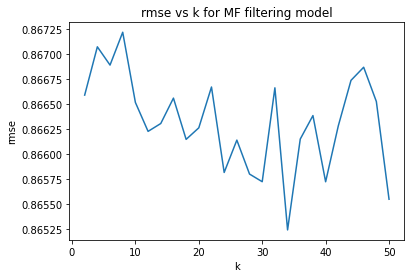

In [46]:
plt.plot(k, rmse_total)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for MF filtering model")

Text(0.5, 1.0, 'mae vs k for MF filtering model')

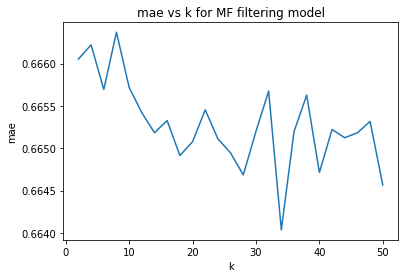

In [47]:
plt.plot(k, mae_total)
plt.xlabel("k")
plt.ylabel("mae")
plt.title("mae vs k for MF filtering model")

#### 10B

In [48]:
min_rmse = min(rmse_total)
min_k = [k[i] for i in range(len(k)) if rmse_total[i] == min_rmse][0]
print("Optimized RMSE:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE: 0.8652407103667132
Optimized corresponding k: 34


In [49]:
min_mae = min(mae_total)
min_k = [k[i] for i in range(len(k)) if mae_total[i] == min_mae][0]
print("Optimized MAE:", min_mae)
print("Optimized corresponding k:", min_k)

Optimized MAE: 0.6640342833252604
Optimized corresponding k: 34


#### 10C

In [50]:
k = range(2,52,2)
rmse_total_popular = []
rmse_total_unpopular = []
rmse_total_variance = []
for i in k:
    rmse_popular = []
    rmse_unpopular = []
    rmse_variance = []

    rmse_total.append(np.mean(cv['test_rmse']))
    mae_total.append(np.mean(cv['test_mae']))

    svd = SVD(n_factors=i, verbose = False)
    for train, test in KFold(n_splits=10).split(new_ratings):
        svd.fit(train)
        popular_trimming_test = trimming(test, method = "popular")
        unpopular_trimming_test = trimming(test, method = "unpopular")
        variance_trimming_test = trimming(test, method = "variance")

        popular_test_pred = svd.test(popular_trimming_test)
        unpopular_test_pred = svd.test(unpopular_trimming_test)
        variance_test_pred = svd.test(variance_trimming_test)

        rmse_popular.append(accuracy.rmse(popular_test_pred, verbose=False))
        rmse_unpopular.append(accuracy.rmse(unpopular_test_pred, verbose=False))
        rmse_variance.append(accuracy.rmse(variance_test_pred, verbose=False))
    rmse_total_popular.append(np.mean(rmse_popular))
    rmse_total_unpopular.append(np.mean(rmse_unpopular))
    rmse_total_variance.append(np.mean(rmse_variance))

Text(0.5, 1.0, 'rmse vs k for popular trimming movies under MF filtering')

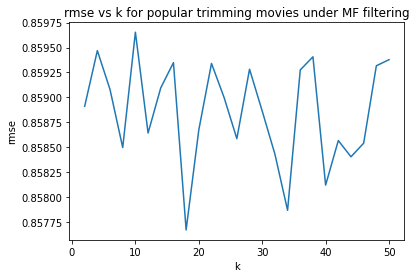

In [51]:
plt.plot(k, rmse_total_popular)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for popular trimming movies under MF filtering")

In [52]:
min_rmse = min(rmse_total_popular)
min_k = [k[i] for i in range(len(k)) if rmse_total_popular[i] == min_rmse][0]
print("Optimized RMSE on popular trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE on popular trimming movies: 0.8576731800794667
Optimized corresponding k: 18


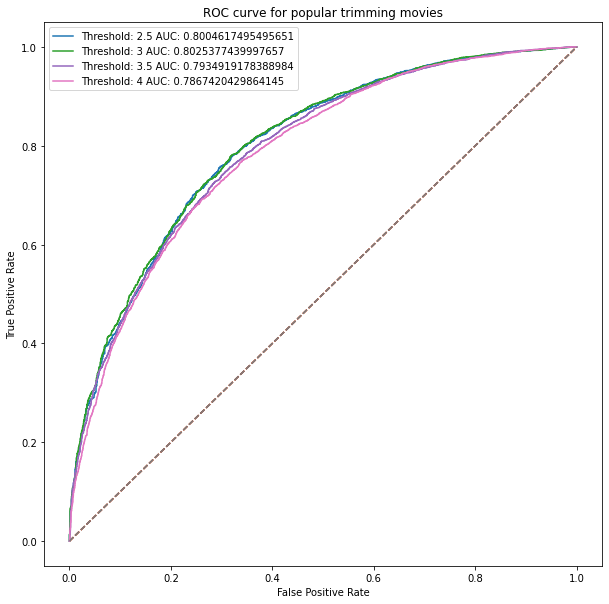

In [53]:
svd = SVD(n_factors=min_k, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
popular_trimming_test = trimming(test, method = "popular")
svd.fit(train)
popular_test_pred = svd.test(popular_trimming_test)
plot_roc(popular_trimming_test, popular_test_pred, "popular trimming movies")

Text(0.5, 1.0, 'rmse vs k for unpopular trimming movies under MF filtering')

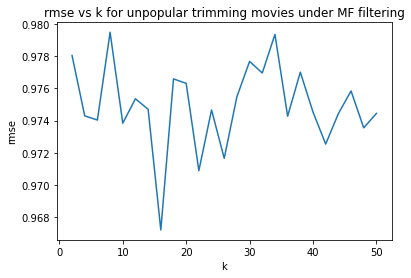

In [54]:
plt.plot(k, rmse_total_unpopular)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for unpopular trimming movies under MF filtering")

In [55]:
min_rmse = min(rmse_total_unpopular)
min_k = [k[i] for i in range(len(k)) if rmse_total_unpopular[i] == min_rmse][0]
print("Optimized RMSE on unpopular trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE on unpopular trimming movies: 0.9672193031919442
Optimized corresponding k: 16


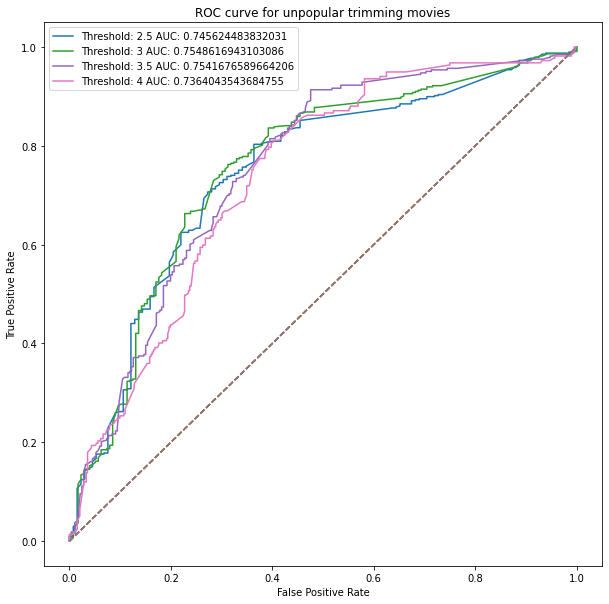

In [56]:
svd = SVD(n_factors=min_k, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
unpopular_trimming_test = trimming(test, method = "unpopular")
svd.fit(train)
unpopular_test_pred = svd.test(unpopular_trimming_test)
plot_roc(unpopular_trimming_test, unpopular_test_pred, "unpopular trimming movies")

Text(0.5, 1.0, 'rmse vs k for high variance trimming movies under MF filtering')

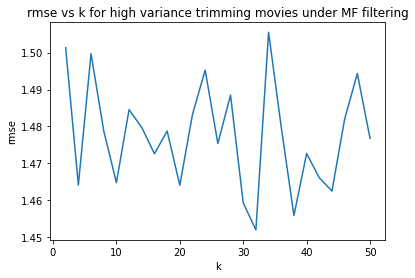

In [57]:
plt.plot(k, rmse_total_variance)
plt.xlabel("k")
plt.ylabel("rmse")
plt.title("rmse vs k for high variance trimming movies under MF filtering")

In [58]:
min_rmse = min(rmse_total_variance)
min_k = [k[i] for i in range(len(k)) if rmse_total_variance[i] == min_rmse][0]
print("Optimized RMSE on popular high variance trimming movies:", min_rmse)
print("Optimized corresponding k:", min_k)

Optimized RMSE on popular high variance trimming movies: 1.451950800960905
Optimized corresponding k: 32


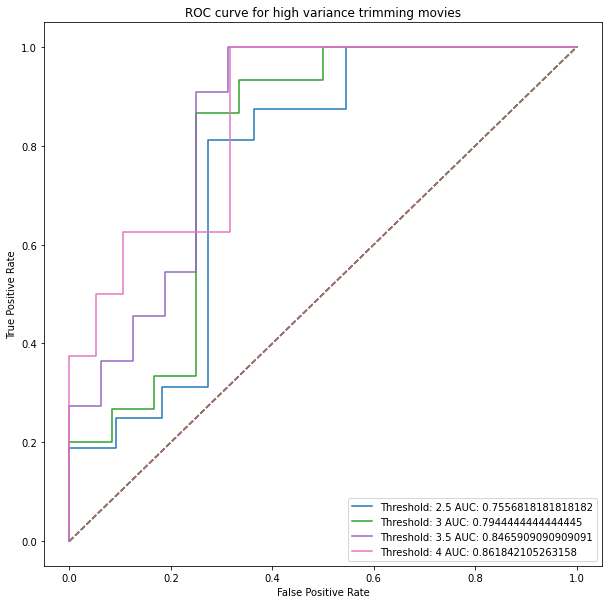

In [59]:
svd = SVD(n_factors=min_k, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
variance_trimming_test = trimming(test, method = "variance")
svd.fit(train)
variance_test_pred = svd.test(variance_trimming_test)
plot_roc(variance_trimming_test, variance_test_pred, "high variance trimming movies")

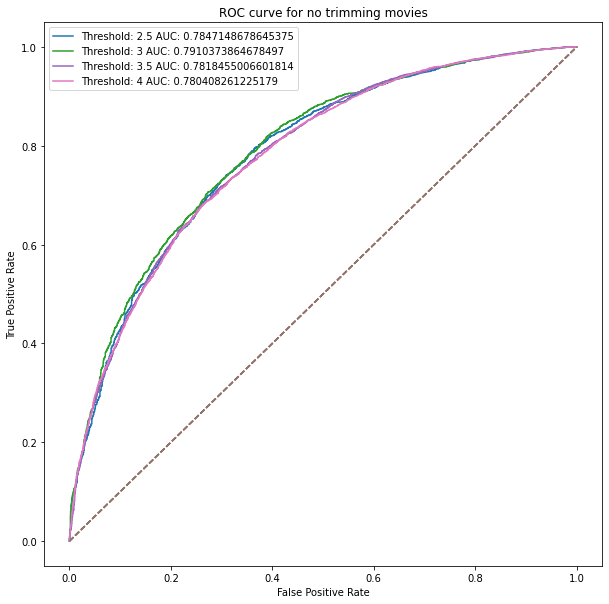

In [60]:
svd = SVD(n_factors=min_k, verbose = False)
train, test = train_test_split(new_ratings, test_size=0.1)
svd.fit(train)
test_pred = svd.test(test)
plot_roc(test, test_pred, "no trimming movies")

Question11

In [82]:
rating_average = ratings.groupby("userId")["rating"].mean()

In [93]:
new_ratings = ratings
new_ratings = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=Reader(rating_scale=(0, 5)))
for train11, test11 in KFold(n_splits=10).split(new_ratings):    
    y_predict11 = [rating_average[i[0]] for i in test11]
    y_test11 = [i[2] for i in test11]        
    RMSE_orighial = np.sqrt(mean_squared_error(y_test11, y_predict11))
Rmse_ori = np.average(RMSE_orighial)
print("The average RMSE of original dataset is", Rmse_ori)

The average RMSE of original dataset is 0.9413209010599004


In [92]:
##Popular
new_ratings = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=Reader(rating_scale=(0, 5)))
for train11, test11 in KFold(n_splits=10).split(new_ratings):
    popular_trimming_test = trimming(test11, method = "popular")    
    y_predict11 = [rating_average[i[0]] for i in popular_trimming_test]
    y_test11 = [i[2] for i in popular_trimming_test]        
    RMSE_pop = np.sqrt(mean_squared_error(y_test11, y_predict11))
Rmse_pop = np.average(RMSE_pop)
print("The average RMSE of Popular dataset is", Rmse_pop)

The average RMSE of Popular dataset is 0.9326821229851671


In [96]:
##Unpopular
new_ratings = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=Reader(rating_scale=(0, 5)))
for train11, test11 in KFold(n_splits=10).split(new_ratings):
    unpopular_trimming_test = trimming(test11, method = "unpopular")    
    y_predict11 = [rating_average[i[0]] for i in unpopular_trimming_test]
    y_test11 = [i[2] for i in unpopular_trimming_test]        
    RMSE_unpop = np.sqrt(mean_squared_error(y_test11, y_predict11))
Rmse_unpop = np.average(RMSE_unpop)
print("The average RMSE of Unpopular dataset is", Rmse_unpop)

The average RMSE of Unpopular dataset is 0.9363260335092686


In [95]:
##High-Variance
new_ratings = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader=Reader(rating_scale=(0, 5)))
for train11, test11 in KFold(n_splits=10).split(new_ratings):
    variance_trimming_test = trimming(test11, method = "variance")    
    y_predict11 = [rating_average[i[0]] for i in variance_trimming_test]
    y_test11 = [i[2] for i in variance_trimming_test]        
    RMSE_variance = np.sqrt(mean_squared_error(y_test11, y_predict11))
Rmse_variance = np.average(RMSE_variance)
print("The average RMSE of High-Variance dataset is", Rmse_variance)

The average RMSE of High-Variance dataset is 1.4538204227630072


Question12

In [101]:
train12, test12 = train_test_split(new_ratings, test_size=0.1)

knn = KNNWithMeans(k=30, sim_options = {'name':'pearson','user_based':True}, verbose = False)
nmf = NMF(n_factors=16, verbose = False)
svd = SVD(n_factors=28, verbose = False)
knn12 = knn.fit(train12).test(test12)
nmf12 = nmf.fit(train12).test(test12)
svd12 = svd.fit(train12).test(test12)


In [98]:
def plot_roc_12(test, pred, title, algorithm):
    thresholds = [3]
    fig, axs = plt.subplots(figsize=(10, 10))
    n = 0
    j =0
    for m in algorithm:
        y_true = []
        y_pred = []
        for i in range(len(test)):
            y_pred.append(pred[j][i].est)
            if test[i][2] >= 3:
                y_true.append(1)
            else:
                y_true.append(0)
        auc = roc_auc_score(y_true, y_pred)
        fpr, tpr, t = roc_curve(y_true, y_pred)
        j += 1
        axs.plot(fpr, tpr, label = 'Threshold: ' + str(3) + " AUC: " + str(auc)+', '+ m)
    axs.set_title("ROC curve for " + title)
    axs.set_xlabel("False Positive Rate")
    axs.set_ylabel("True Positive Rate")
    axs.legend()
    axs.plot([0, 1], [0, 1], '--')


In [99]:
algorithm = ['KNN', 'NMF', 'MF']
pred12 = [knn12,nmf12,svd12]

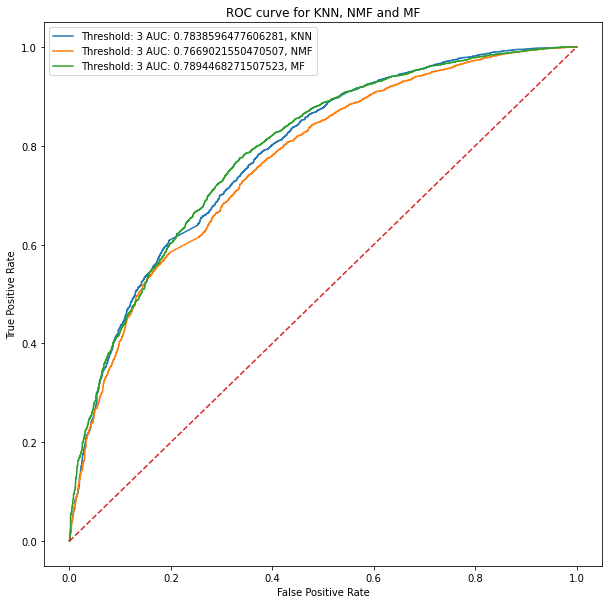

In [100]:
plot_roc_12(test12, pred12, 'KNN, NMF and MF', algorithm)

Question14

14A

In [70]:
from collections import defaultdict
def G(test, t):
    result = []
    users = defaultdict(int)
    rating_3 = {}
    for i in test:
        users[i[0]] += 1
        if i[2] >= 3:
            rating_3[i[0]] = 1
    for i in test:
        if users[i[0]] >= t and i[0] in rating_3:
            result.append(i)
    return result

In [71]:
def precision_recall(prediction, t):
  est_true_rating = defaultdict(list)
  precision = []
  recall =[]
  for uid, iid, r_ui, est, details in prediction:
      est_true_rating[uid].append((est,r_ui))

  for uid, ratings in est_true_rating.items():
    true_rating_precision = []
    true_rating_recall = []
    ratings.sort(key=lambda x: x[0], reverse=True)
    top = ratings[:t]
    for est, true_rating in top:
      if true_rating >= 3:
        true_rating_precision.append(1)
    mixed_tG = len(true_rating_precision)
    for est, true_rating in ratings:
      if true_rating >= 3:
        true_rating_recall.append(1)
    recommend = len(true_rating_recall)
    precision_temp = mixed_tG/t
    recall_temp = mixed_tG/recommend
    precision.append(precision_temp)
    recall.append(recall_temp)
  precision14 = np.average(precision)
  recall14 = np.average(recall)
  return precision14, recall14

In [72]:
precision_knn = []
recall_knn = []
for t in range(1,26):
  precision_t = []
  recall_t = []
  for train, test in KFold(n_splits=10).split(new_ratings):
    g = G(test, t)
    knn = KNNWithMeans(k=30,sim_options={'name':'pearson'},verbose=False)
    knn.fit(train)
    prediction = knn.test(g)
    precision, recall = precision_recall(prediction, t)
    precision_t.append(precision)
    recall_t.append(recall)
  precision_avg = np.average(precision_t)
  recall_avg = np.average(recall_t)
  precision_knn.append(precision_avg)
  recall_knn.append(recall_avg)


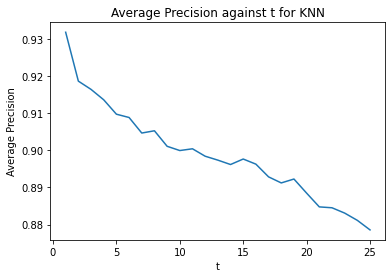

In [73]:
import matplotlib.pyplot as plt
t = np.arange(1, 26)

plt.plot(t,precision_knn)
plt.title('Average Precision against t for KNN')
plt.xlabel('t')
plt.ylabel('Average Precision')
plt.show()

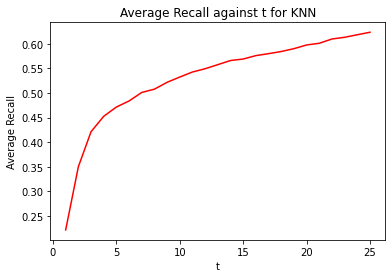

In [74]:
plt.plot(t,recall_knn, 'r')
plt.title('Average Recall against t for KNN')
plt.xlabel('t')
plt.ylabel('Average Recall')
plt.show()

In [75]:
precision_nmf = []
recall_nmf = []
for t in range(1,26):
  precision_t = []
  recall_t = []
  for train, test in KFold(n_splits=10).split(new_ratings):
    g = G(test, t)
    nmf = NMF(n_factors=16,verbose=False)
    nmf.fit(train)
    prediction = nmf.test(g)
    precision, recall = precision_recall(prediction, t)
    precision_t.append(precision)
    recall_t.append(recall)
  precision_avg = np.average(precision_t)
  recall_avg = np.average(recall_t)
  precision_nmf.append(precision_avg)
  recall_nmf.append(recall_avg)

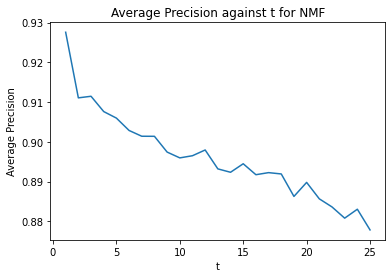

In [76]:
t = np.arange(1, 26)
plt.plot(t, precision_nmf, )
plt.title('Average Precision against t for NMF')
plt.xlabel('t')
plt.ylabel('Average Precision')
plt.show()

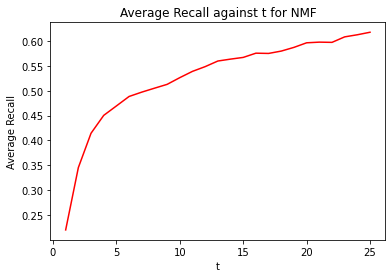

In [77]:
plt.plot(t, recall_nmf, 'r')
plt.title('Average Recall against t for NMF')
plt.xlabel('t')
plt.ylabel('Average Recall')
plt.show()

In [78]:
precision_svd = []
recall_svd = []
for t in range(1,26):
  precision_t = []
  recall_t = []
  for train, test in KFold(n_splits=10).split(new_ratings):
    g = G(test, t)
    svd = SVD(n_factors=28, verbose = False)
    svd.fit(train)
    prediction = svd.test(g)
    precision, recall = precision_recall(prediction, t)
    precision_t.append(precision)
    recall_t.append(recall)
  precision_avg = np.average(precision_t)
  recall_avg = np.average(recall_t)
  precision_svd.append(precision_avg)
  recall_svd.append(recall_avg)

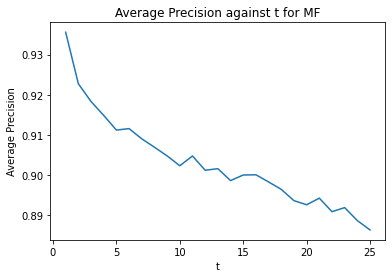

In [79]:
t = np.arange(1, 26)
plt.plot(t,precision_svd)
plt.title('Average Precision against t for MF')
plt.xlabel('t')
plt.ylabel('Average Precision')
plt.show()

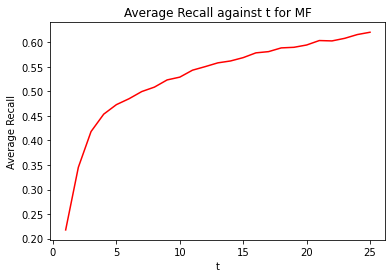

In [80]:
plt.plot(t,recall_svd, 'r')
plt.title('Average Recall against t for MF')
plt.xlabel('t')
plt.ylabel('Average Recall')
plt.show()

14B

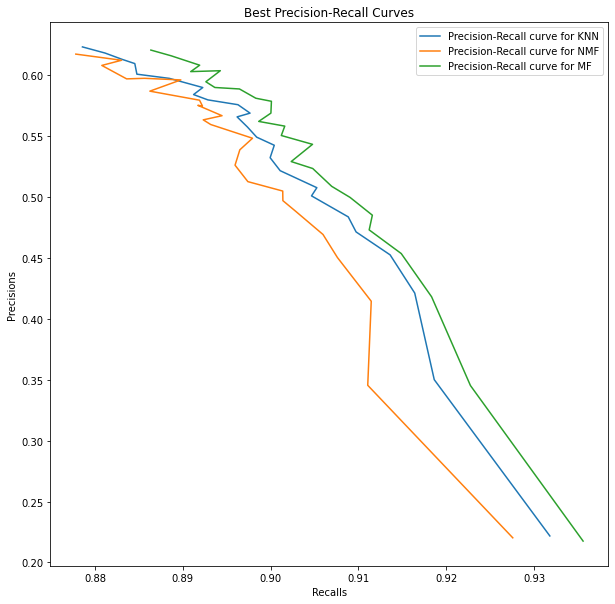

In [81]:
fig, axs = plt.subplots(figsize=(10, 10))
axs.plot(precision_knn, recall_knn, label = 'Precision-Recall curve for KNN')
axs.plot(precision_nmf, recall_nmf, label = 'Precision-Recall curve for NMF')
axs.plot(precision_svd, recall_svd, label = 'Precision-Recall curve for MF')
axs.set_title("Best Precision-Recall Curves")
axs.set_xlabel("Recalls")
axs.set_ylabel("Precisions")
axs.legend()
plt.show()
